# EPOCH Mini Project
- 공공 도서관 데이터
    - 2020 ~ 2021년, 국립 중앙 도서관
    - [프로젝트 안내](https://file.notion.so/f/f/6e4351d1-ed91-4b42-b856-3661f9da0ed2/7fcfcdd1-b155-4e2d-9e90-74bf86736e4d/EPOCH_MiniProject_%EC%A3%BC%EC%9A%94%EC%95%88%EB%82%B4.pdf?table=block&id=1c80de90-854f-8021-9337-ebfa9c28f572&spaceId=6e4351d1-ed91-4b42-b856-3661f9da0ed2&expirationTimestamp=1743724800000&signature=e83tQZtwsN39XR8MWcJOoPaLu_YkXX0ju5LSY6bw05E&downloadName=EPOCH_MiniProject_%EC%A3%BC%EC%9A%94%EC%95%88%EB%82%B4.pdf)

## 1. 데이터셋 불러오기

In [1]:
import numpy as np
import pandas as pd
# from unidecode import unidecode

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
import plotly.express as px

# import requests
import os
import json

from datetime import datetime
from datetime import timedelta
# import missingno as msno

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option("display.max_columns", None)

# 시각화 폰트 설정 (본고딕)
plt.rc('font', family='Noto Sans KR')
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [2]:
# 도서별 상세 정보
books_df = pd.read_csv("data/books/books.csv")

# 도서관 정보
library_df = pd.read_csv("data/library/library.csv")

# 공공 도서관 소장도서
library_books_df = pd.read_csv("data/library_books/library_books.csv")

In [3]:
# 인기 대출
# loan_information_df = pd.read_csv("data/loan_information/loan_information.csv")

# # 인기 대출 1
# loan_rank_2020 = pd.read_csv("data/loan_information/loan_rank_2020.csv")

# # 인기 대출 2
# loan_rank_2021 = pd.read_csv("data/loan_information/loan_rank_2021.csv")

# 인기 대출 front
loan_front_df = pd.read_pickle("data/loan_information/loan_front_part.pkl")
print("loan_front_df 파일이 성공적으로 불러와졌습니다.")

# 인기 대출 back
loan_back_df = pd.read_pickle("data/loan_information/loan_back_part.pkl")
print("loan_back_df 파일이 성공적으로 불러와졌습니다.")

loan_front_df 파일이 성공적으로 불러와졌습니다.
loan_back_df 파일이 성공적으로 불러와졌습니다.


## 2. 전처리

### 2-1. 인기 대출 데이터셋

In [4]:
# 인기 대출 front, 인기 대출 back 데이터셋 하나로 concat
loan_information_df = pd.concat([loan_front_df, loan_back_df])

In [5]:
# KDC_NM 컬럼에 따라 KDC_NUM (KDC 번호), KDC_GENRE (장르 이름) 컬럼 생성
def map_kdc_columns(df, kdc_col):

    # kdc_col 컬럼은 문자열이라고 가정하고 좌우 공백 제거
    col_series = df[kdc_col].astype(str).str.strip()
    
    # 결측치가 아닌 행과, 첫 글자가 "0", "1", ..., "9" 중 하나로 시작하는 행 선택
    mask = col_series.str.startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9"), na=False)
    
    # 첫 번째 문자에 해당하는 숫자를 정수로 변환하고 100을 곱하여 "KDC_NUM" 컬럼 생성
    kdc_num = col_series[mask].str[0].astype(int) * 100
    df.loc[mask, "KDC_NUM"] = kdc_num
    
    # 매핑 딕셔너리 정의 (100 ~ 900 값에 대응하는 장르)
    genre_mapping = {
        100: "철학",
        200: "종교",
        300: "사회과학",
        400: "자연과학",
        500: "기술 과학",
        600: "예술",
        700: "언어",
        800: "문학",
        900: "역사"
    }
    
    # "KDC_NUM" 값을 이용하여 "KDC_GENRE" 컬럼 생성
    df.loc[mask, "KDC_GENRE"] = kdc_num.map(genre_mapping)
    
    return df

In [6]:
loan_information_df = map_kdc_columns(loan_information_df, kdc_col="KDC_NM")

In [7]:
# 1단계: ISBN_THIRTEEN_NO 별로 그룹화하고 ANALS_LON_TOT_CO의 합계 계산
loan_df_grouped = loan_information_df.groupby("ISBN_THIRTEEN_NO")["ANALS_LON_TOT_CO"].sum().reset_index()

# 2단계: ANALS_LON_TOT_CO 합계를 기준으로 내림차순 정렬
loan_df_grouped = loan_df_grouped.sort_values("ANALS_LON_TOT_CO", ascending=False)

# 3단계: pandas의 rank() 함수를 사용하여 Rank 컬럼 추가 (동점 처리 가능)
loan_df_grouped["Rank"] = loan_df_grouped["ANALS_LON_TOT_CO"].rank(method="min", ascending=False)

# 결과 출력
print(loan_df_grouped)


       ISBN_THIRTEEN_NO  ANALS_LON_TOT_CO     Rank
48748     9791164130764        1586494271      1.0
23187     9788949161969        1461221124      2.0
46004     9791158360375        1449225929      3.0
41154     9788993242706        1398401813      4.0
45995     9791158360214        1378438912      5.0
...                 ...               ...      ...
53502     9791189279899                50  56650.0
53636     9791189497293                50  56650.0
46611     9791159066047                50  56650.0
36692     9788972772064                50  56650.0
39782     9788989847632                50  56650.0

[56657 rows x 3 columns]


In [8]:
loan_merge_cols = [
    "ISBN_THIRTEEN_NO", "KDC_NUM", "KDC_GENRE"
]

loan_merged = pd.merge(loan_df_grouped, loan_information_df[loan_merge_cols], 
         how="left", on="ISBN_THIRTEEN_NO").drop_duplicates()
loan_merged

ISBN_THIRTEEN_NO  ANALS_LON_TOT_CO     Rank  KDC_NUM KDC_GENRE
0           9791164130764        1586494271      1.0    800.0        문학
1545        9788949161969        1461221124      2.0    800.0        문학
2912        9791158360375        1449225929      3.0    800.0        문학
4406        9788993242706        1398401813      4.0    800.0        문학
5863        9791158360214        1378438912      5.0    800.0        문학
...                   ...               ...      ...      ...       ...
1498527     9791189279899                50  56650.0    800.0        문학
1498528     9791189497293                50  56650.0      NaN       NaN
1498529     9791159066047                50  56650.0      NaN       NaN
1498530     9788972772064                50  56650.0    300.0      사회과학
1498531     9788989847632                50  56650.0    500.0     기술 과학

[57559 rows x 5 columns]

In [9]:
# ISBN_THIRTEEN_NO 기준으로 그룹화하여 결측치 채우기
for isbn, group in loan_merged.groupby('ISBN_THIRTEEN_NO'):
    # 처리할 컬럼 리스트
    columns_to_fill = ['KDC_NUM', 'KDC_GENRE']
    for col in columns_to_fill:
        # 그룹 내에서 결측치가 아닌 값 추출
        non_null_values = group[col].dropna()
        if not non_null_values.empty:
            # mode 값 계산 (여러 개일 경우 첫 번째 값 사용)
            mode_value = non_null_values.mode().iloc[0]
            # 해당 그룹에서 col 컬럼의 결측치 업데이트
            loan_merged.loc[
                (loan_merged['ISBN_THIRTEEN_NO'] == isbn) & (loan_merged[col].isna()),
                col
            ] = mode_value
            print(f"ISBN {isbn}의 {col} 결측치가 {mode_value}(으)로 대체되었습니다.")
        else:
            print(f"ISBN {isbn}에 대해 채울 수 있는 {col} 값이 없습니다.")

# 결과 확인
print(loan_merged)

ISBN 0에 대해 채울 수 있는 KDC_NUM 값이 없습니다.
ISBN 0에 대해 채울 수 있는 KDC_GENRE 값이 없습니다.
ISBN 125669에 대해 채울 수 있는 KDC_NUM 값이 없습니다.
ISBN 125669에 대해 채울 수 있는 KDC_GENRE 값이 없습니다.
ISBN 978019846373의 KDC_NUM 결측치가 700.0(으)로 대체되었습니다.
ISBN 978019846373의 KDC_GENRE 결측치가 언어(으)로 대체되었습니다.
ISBN 978890107411의 KDC_NUM 결측치가 800.0(으)로 대체되었습니다.
ISBN 978890107411의 KDC_GENRE 결측치가 문학(으)로 대체되었습니다.
ISBN 1060443900000의 KDC_NUM 결측치가 800.0(으)로 대체되었습니다.
ISBN 1060443900000의 KDC_GENRE 결측치가 문학(으)로 대체되었습니다.
ISBN 1090051900000의 KDC_NUM 결측치가 800.0(으)로 대체되었습니다.
ISBN 1090051900000의 KDC_GENRE 결측치가 문학(으)로 대체되었습니다.
ISBN 1090261900000의 KDC_NUM 결측치가 800.0(으)로 대체되었습니다.
ISBN 1090261900000의 KDC_GENRE 결측치가 문학(으)로 대체되었습니다.
ISBN 1157843883979에 대해 채울 수 있는 KDC_NUM 값이 없습니다.
ISBN 1157843883979에 대해 채울 수 있는 KDC_GENRE 값이 없습니다.
ISBN 1160944601979의 KDC_NUM 결측치가 800.0(으)로 대체되었습니다.
ISBN 1160944601979의 KDC_GENRE 결측치가 문학(으)로 대체되었습니다.
ISBN 1164381458979에 대해 채울 수 있는 KDC_NUM 값이 없습니다.
ISBN 1164381458979에 대해 채울 수 있는 KDC_GENRE 값이 없습니다.
ISBN 1187113042979의 KDC_NUM 결측치가

In [21]:
loan_merged.isnull().sum()

ISBN_THIRTEEN_NO        0
ANALS_LON_TOT_CO        0
Rank                    0
KDC_NUM             13266
KDC_GENRE           13266
dtype: int64

In [22]:
loan_merged

ISBN_THIRTEEN_NO  ANALS_LON_TOT_CO     Rank  KDC_NUM KDC_GENRE
0          9791164130764        1586494271      1.0    800.0        문학
1545       9788949161969        1461221124      2.0    800.0        문학
2912       9791158360375        1449225929      3.0    800.0        문학
4406       9788993242706        1398401813      4.0    800.0        문학
5863       9791158360214        1378438912      5.0    800.0        문학
...                  ...               ...      ...      ...       ...
1498527    9791189279899                50  56650.0    800.0        문학
1498528    9791189497293                50  56650.0      NaN       NaN
1498529    9791159066047                50  56650.0      NaN       NaN
1498530    9788972772064                50  56650.0    300.0      사회과학
1498531    9788989847632                50  56650.0    500.0     기술 과학

[56657 rows x 5 columns]

In [23]:
loan_merged.drop_duplicates(subset="ISBN_THIRTEEN_NO", keep="first", inplace=True)

In [24]:
loan_merged

ISBN_THIRTEEN_NO  ANALS_LON_TOT_CO     Rank  KDC_NUM KDC_GENRE
0          9791164130764        1586494271      1.0    800.0        문학
1545       9788949161969        1461221124      2.0    800.0        문학
2912       9791158360375        1449225929      3.0    800.0        문학
4406       9788993242706        1398401813      4.0    800.0        문학
5863       9791158360214        1378438912      5.0    800.0        문학
...                  ...               ...      ...      ...       ...
1498527    9791189279899                50  56650.0    800.0        문학
1498528    9791189497293                50  56650.0      NaN       NaN
1498529    9791159066047                50  56650.0      NaN       NaN
1498530    9788972772064                50  56650.0    300.0      사회과학
1498531    9788989847632                50  56650.0    500.0     기술 과학

[56657 rows x 5 columns]

In [25]:
# 1. ISBN별 등장 횟수 세기
isbn_counts = loan_merged['ISBN_THIRTEEN_NO'].value_counts()

# 2. 2번 이상 등장하는 ISBN만 필터링
duplicated_isbns = isbn_counts[isbn_counts > 1].index

# 3. 원본 데이터프레임에서 해당 ISBN들만 필터링
loan_merged_duplicated_isbn = loan_merged[loan_merged['ISBN_THIRTEEN_NO'].isin(duplicated_isbns)]

In [26]:
loan_merged_duplicated_isbn.drop_duplicates()

Empty DataFrame
Columns: [ISBN_THIRTEEN_NO, ANALS_LON_TOT_CO, Rank, KDC_NUM, KDC_GENRE]
Index: []

In [27]:
loan_merged["ISBN_THIRTEEN_NO"] = loan_merged["ISBN_THIRTEEN_NO"].astype("str")

### 2-2. 데이터셋 merge
- `loan_merged`, `library_books_df`, `library_df`

In [28]:
# 공공도서관 소장 데이터에서 사용할 컬럼 정의
library_books_cols = [
    "AUTHR_NM", "PBLICTE_YEAR", "LBRRY_CD", "ISBN_THIRTEEN_NO", "REPRSNT_BOOK_AT"
]

In [29]:
library_books_df.shape

(2074742, 32)

In [30]:
loan_merged

ISBN_THIRTEEN_NO  ANALS_LON_TOT_CO     Rank  KDC_NUM KDC_GENRE
0          9791164130764        1586494271      1.0    800.0        문학
1545       9788949161969        1461221124      2.0    800.0        문학
2912       9791158360375        1449225929      3.0    800.0        문학
4406       9788993242706        1398401813      4.0    800.0        문학
5863       9791158360214        1378438912      5.0    800.0        문학
...                  ...               ...      ...      ...       ...
1498527    9791189279899                50  56650.0    800.0        문학
1498528    9791189497293                50  56650.0      NaN       NaN
1498529    9791159066047                50  56650.0      NaN       NaN
1498530    9788972772064                50  56650.0    300.0      사회과학
1498531    9788989847632                50  56650.0    500.0     기술 과학

[56657 rows x 5 columns]

In [31]:
library_books_df['ISBN_THIRTEEN_NO'] = library_books_df['ISBN_THIRTEEN_NO'].astype(str).str.replace('.0', '', regex=False)


In [32]:
# 공공도서관 소장 데이터와 ISBN 코드로 인기 대출 데이터셋 중복 제거한 것 merge
library_books_loan_merged = pd.merge(library_books_df[library_books_cols], loan_merged, how="left", on="ISBN_THIRTEEN_NO")
library_books_loan_merged

AUTHR_NM PBLICTE_YEAR  \
0                                               차홍규,김성진 엮음         2018   
1                                    데브라 N. 맨커프 지음 ;안희정 옮김         2021   
2                                                   윤희솔 지음         2021   
3                                               박형주,김지연 지음         2020   
4                                                   김수민 지음         2021   
...                                                    ...          ...   
2074737                                    안수현 지음 ; 이기섭 엮음         2009   
2074738                                              최춘언 저         2009   
2074739  Yunus A. ¸Cengel ; Michael A. Boles [공]저 ; 김덕줄...         2004   
2074740                                        이대호, 박영태 공저         2008   
2074741                           김수병 [외] 지음 ; 한국과학창의재단 기획         2009   

         LBRRY_CD ISBN_THIRTEEN_NO REPRSNT_BOOK_AT  ANALS_LON_TOT_CO    Rank  \
0            1501    9788965781325               Y               NaN     NaN   
1            1501    9791155813386               Y         5908795.0  8148.0   
2            1501    9788925588698               Y               NaN     NaN   
3            1501    9788988964477               Y        83228337.0  2139.0   
4            1501    9791197037191               Y               NaN     NaN   
...           ...              ...             ...               ...     ...   
2074737     29528    9788991066700             NaN               NaN     NaN   
2074738     29528    9788991978089             NaN               NaN     NaN   
2074739     29528    9788988825693             NaN               NaN     NaN   
2074740     29528    9788956674216             NaN               NaN     NaN   
2074741     29528    9788956053882             NaN               NaN     NaN   

         KDC_NUM KDC_GENRE  
0            NaN       NaN  
1          600.0        예술  
2            NaN       NaN  
3          200.0        종교  
4            NaN       NaN  
...          ...       ...  
2074737      NaN       NaN  
2074738      NaN       NaN  
2074739      NaN       NaN  
2074740      NaN       NaN  
2074741      NaN       NaN  

[2074742 rows x 9 columns]

In [33]:
library_books_loan_merged.isnull().sum()

AUTHR_NM              16394
PBLICTE_YEAR          18465
LBRRY_CD                  0
ISBN_THIRTEEN_NO          0
REPRSNT_BOOK_AT     1355645
ANALS_LON_TOT_CO    1597968
Rank                1597968
KDC_NUM             1693297
KDC_GENRE           1693297
dtype: int64

In [34]:
1597968 / library_books_loan_merged.shape[0]

0.7702008249700445

In [35]:
# 도서관 정보에서 사용할 컬럼 정의의
library_cols = [
    "LBRRY_CD", "LBRRY_NM", "LBRRY_ADDR", "ONE_AREA_NM", "TWO_AREA_NM",
    "LBRRY_TY_CD", "LBRRY_TY_NM", "FOND_MBY_VALUE", "AREA_CD"
]

In [36]:
# library_books_loan_merged, 도서관 정보 데이터셋 merge
merged_total = pd.merge(library_books_loan_merged, library_df[library_cols],  how="left", on="LBRRY_CD")
merged_total

AUTHR_NM PBLICTE_YEAR  \
0                                               차홍규,김성진 엮음         2018   
1                                    데브라 N. 맨커프 지음 ;안희정 옮김         2021   
2                                                   윤희솔 지음         2021   
3                                               박형주,김지연 지음         2020   
4                                                   김수민 지음         2021   
...                                                    ...          ...   
2074737                                    안수현 지음 ; 이기섭 엮음         2009   
2074738                                              최춘언 저         2009   
2074739  Yunus A. ¸Cengel ; Michael A. Boles [공]저 ; 김덕줄...         2004   
2074740                                        이대호, 박영태 공저         2008   
2074741                           김수병 [외] 지음 ; 한국과학창의재단 기획         2009   

         LBRRY_CD ISBN_THIRTEEN_NO REPRSNT_BOOK_AT  ANALS_LON_TOT_CO    Rank  \
0            1501    9788965781325               Y               NaN     NaN   
1            1501    9791155813386               Y         5908795.0  8148.0   
2            1501    9788925588698               Y               NaN     NaN   
3            1501    9788988964477               Y        83228337.0  2139.0   
4            1501    9791197037191               Y               NaN     NaN   
...           ...              ...             ...               ...     ...   
2074737     29528    9788991066700             NaN               NaN     NaN   
2074738     29528    9788991978089             NaN               NaN     NaN   
2074739     29528    9788988825693             NaN               NaN     NaN   
2074740     29528    9788956674216             NaN               NaN     NaN   
2074741     29528    9788956053882             NaN               NaN     NaN   

         KDC_NUM KDC_GENRE       LBRRY_NM               LBRRY_ADDR  \
0            NaN       NaN      포천시립소흘도서관   경기도 포천시 소흘읍 송우로 101-29   
1          600.0        예술      포천시립소흘도서관   경기도 포천시 소흘읍 송우로 101-29   
2            NaN       NaN      포천시립소흘도서관   경기도 포천시 소흘읍 송우로 101-29   
3          200.0        종교      포천시립소흘도서관   경기도 포천시 소흘읍 송우로 101-29   
4            NaN       NaN      포천시립소흘도서관   경기도 포천시 소흘읍 송우로 101-29   
...          ...       ...            ...                      ...   
2074737      NaN       NaN  경상북도교육청 울릉도서관  경상북도 울릉군 울릉읍 봉래길 128-10   
2074738      NaN       NaN  경상북도교육청 울릉도서관  경상북도 울릉군 울릉읍 봉래길 128-10   
2074739      NaN       NaN  경상북도교육청 울릉도서관  경상북도 울릉군 울릉읍 봉래길 128-10   
2074740      NaN       NaN  경상북도교육청 울릉도서관  경상북도 울릉군 울릉읍 봉래길 128-10   
2074741      NaN       NaN  경상북도교육청 울릉도서관  경상북도 울릉군 울릉읍 봉래길 128-10   

        ONE_AREA_NM TWO_AREA_NM  LBRRY_TY_CD LBRRY_TY_NM FOND_MBY_VALUE  \
0               경기도         포천시            1          공공            지자체   
1               경기도         포천시            1          공공            지자체   
2               경기도         포천시            1          공공            지자체   
3               경기도         포천시            1          공공            지자체   
4               경기도         포천시            1          공공            지자체   
...             ...         ...          ...         ...            ...   
2074737        경상북도         울릉군            1          공공            교육청   
2074738        경상북도         울릉군            1          공공            교육청   
2074739        경상북도         울릉군            1          공공            교육청   
2074740        경상북도         울릉군            1          공공            교육청   
2074741        경상북도         울릉군            1          공공            교육청   

         AREA_CD  
0              7  
1              7  
2              7  
3              7  
4              7  
...          ...  
2074737       11  
2074738       11  
2074739       11  
2074740       11  
2074741       11  

[2074742 rows x 17 columns]

In [53]:
merged_total.shape

(2074742, 17)

In [38]:
library_books_loan_merged.isnull().sum()

AUTHR_NM              16394
PBLICTE_YEAR          18465
LBRRY_CD                  0
ISBN_THIRTEEN_NO          0
REPRSNT_BOOK_AT     1355645
ANALS_LON_TOT_CO    1597968
Rank                1597968
KDC_NUM             1693297
KDC_GENRE           1693297
dtype: int64

In [39]:
library_books_loan_merged_copy = library_books_loan_merged.copy()

In [40]:
library_books_loan_merged_copy.dropna(subset=["KDC_GENRE"], inplace=True)

In [41]:
library_books_loan_merged_copy = library_books_loan_merged_copy[
    ['AUTHR_NM', 'PBLICTE_YEAR', 'LBRRY_CD', 'ISBN_THIRTEEN_NO', 
     'ANALS_LON_TOT_CO', 'Rank', 'KDC_NUM', 'KDC_GENRE']
]

In [61]:
merged_dataset = pd.merge(library_books_loan_merged_copy, library_df[library_cols],  how="left", on="LBRRY_CD")

In [51]:
library_books_loan_merged_copy.shape

(381445, 8)

In [63]:
merged_dataset.shape

(381445, 16)

In [65]:
merged_dataset = merged_dataset.dropna().reset_index(drop=True)

In [66]:
merged_dataset

AUTHR_NM PBLICTE_YEAR  LBRRY_CD ISBN_THIRTEEN_NO  \
0       데브라 N. 맨커프 지음 ;안희정 옮김         2021      1501    9791155813386   
1                  박형주,김지연 지음         2020      1501    9788988964477   
2         데구치 하루아키 지음 ;서수지 엮음         2021      1501    9788972917434   
3           조 디스펜자 지음 ;추미란 옮김         2019      1501    9791188244454   
4                      윤재수 지음         2020      1501    9791165210519   
...                       ...          ...       ...              ...   
350222      팻 허친즈 지음 ; 서남희 옮김         2007     29528    9788911026821   
350223         이민혜 글 ; 오정택 그림         2008     29528    9788954605014   
350224                 용대운 지음         2009     29528    9788951023439   
350225         임길택 글 ; 김동성 그림         2008     29528    9788955820829   
350226                 검류혼 지음         2009     29528    9788925119229   

        ANALS_LON_TOT_CO     Rank  KDC_NUM KDC_GENRE       LBRRY_NM  \
0              5908795.0   8148.0    600.0        예술      포천시립소흘도서관   
1             83228337.0   2139.0    200.0        종교      포천시립소흘도서관   
2              4416663.0   9112.0    100.0        철학      포천시립소흘도서관   
3                 1964.0  54825.0    100.0        철학      포천시립소흘도서관   
4             70378996.0   2343.0    300.0      사회과학      포천시립소흘도서관   
...                  ...      ...      ...       ...            ...   
350222          317518.0  19603.0    800.0        문학  경상북도교육청 울릉도서관   
350223           45474.0  33740.0    800.0        문학  경상북도교육청 울릉도서관   
350224           70593.0  29601.0    800.0        문학  경상북도교육청 울릉도서관   
350225          167744.0  23050.0    800.0        문학  경상북도교육청 울릉도서관   
350226         1977427.0  12083.0    800.0        문학  경상북도교육청 울릉도서관   

                     LBRRY_ADDR ONE_AREA_NM TWO_AREA_NM  LBRRY_TY_CD  \
0        경기도 포천시 소흘읍 송우로 101-29         경기도         포천시            1   
1        경기도 포천시 소흘읍 송우로 101-29         경기도         포천시            1   
2        경기도 포천시 소흘읍 송우로 101-29         경기도         포천시            1   
3        경기도 포천시 소흘읍 송우로 101-29         경기도         포천시            1   
4        경기도 포천시 소흘읍 송우로 101-29         경기도         포천시            1   
...                         ...         ...         ...          ...   
350222  경상북도 울릉군 울릉읍 봉래길 128-10        경상북도         울릉군            1   
350223  경상북도 울릉군 울릉읍 봉래길 128-10        경상북도         울릉군            1   
350224  경상북도 울릉군 울릉읍 봉래길 128-10        경상북도         울릉군            1   
350225  경상북도 울릉군 울릉읍 봉래길 128-10        경상북도         울릉군            1   
350226  경상북도 울릉군 울릉읍 봉래길 128-10        경상북도         울릉군            1   

       LBRRY_TY_NM FOND_MBY_VALUE  AREA_CD  
0               공공            지자체        7  
1               공공            지자체        7  
2               공공            지자체        7  
3               공공            지자체        7  
4               공공            지자체        7  
...            ...            ...      ...  
350222          공공            교육청       11  
350223          공공            교육청       11  
350224          공공            교육청       11  
350225          공공            교육청       11  
350226          공공            교육청       11  

[350227 rows x 16 columns]

In [67]:
# merged_dataset를 pickle 파일로 저장하기
merged_dataset.to_pickle("data/merged_dataset.pkl")
print("merged_dataset 파일이 'data/merged_dataset.pkl'로 저장되었습니다.")

merged_dataset 파일이 'data/merged_dataset.pkl'로 저장되었습니다.


## 3. EDA

In [2]:
# 인기 대출 front
merged_dataset = pd.read_pickle("data/merged_dataset.pkl")
print("merged_dataset 파일이 성공적으로 불러와졌습니다.")

merged_dataset 파일이 성공적으로 불러와졌습니다.


In [3]:
merged_dataset.shape

(350227, 16)

In [4]:
merged_dataset["LBRRY_CD"] = merged_dataset["LBRRY_CD"].astype(str)
merged_dataset["LBRRY_TY_CD"] = merged_dataset["LBRRY_TY_CD"].astype(str)

In [5]:
merged_dataset.head(3)

AUTHR_NM PBLICTE_YEAR LBRRY_CD ISBN_THIRTEEN_NO  \
0  데브라 N. 맨커프 지음 ;안희정 옮김         2021     1501    9791155813386   
1             박형주,김지연 지음         2020     1501    9788988964477   
2    데구치 하루아키 지음 ;서수지 엮음         2021     1501    9788972917434   

   ANALS_LON_TOT_CO    Rank  KDC_NUM KDC_GENRE   LBRRY_NM  \
0         5908795.0  8148.0    600.0        예술  포천시립소흘도서관   
1        83228337.0  2139.0    200.0        종교  포천시립소흘도서관   
2         4416663.0  9112.0    100.0        철학  포천시립소흘도서관   

               LBRRY_ADDR ONE_AREA_NM TWO_AREA_NM LBRRY_TY_CD LBRRY_TY_NM  \
0  경기도 포천시 소흘읍 송우로 101-29         경기도         포천시           1          공공   
1  경기도 포천시 소흘읍 송우로 101-29         경기도         포천시           1          공공   
2  경기도 포천시 소흘읍 송우로 101-29         경기도         포천시           1          공공   

  FOND_MBY_VALUE  AREA_CD  
0            지자체        7  
1            지자체        7  
2            지자체        7

### 3-1. 범주형 변수 시각화

In [6]:
cat_cols = merged_dataset.select_dtypes(exclude=np.number).columns
num_cols = merged_dataset.select_dtypes(include=np.number).columns

In [7]:
cat_cols

Index(['AUTHR_NM', 'PBLICTE_YEAR', 'LBRRY_CD', 'ISBN_THIRTEEN_NO', 'KDC_GENRE',
       'LBRRY_NM', 'LBRRY_ADDR', 'ONE_AREA_NM', 'TWO_AREA_NM', 'LBRRY_TY_CD',
       'LBRRY_TY_NM', 'FOND_MBY_VALUE'],
      dtype='object')

In [8]:
num_cols

Index(['ANALS_LON_TOT_CO', 'Rank', 'KDC_NUM', 'AREA_CD'], dtype='object')

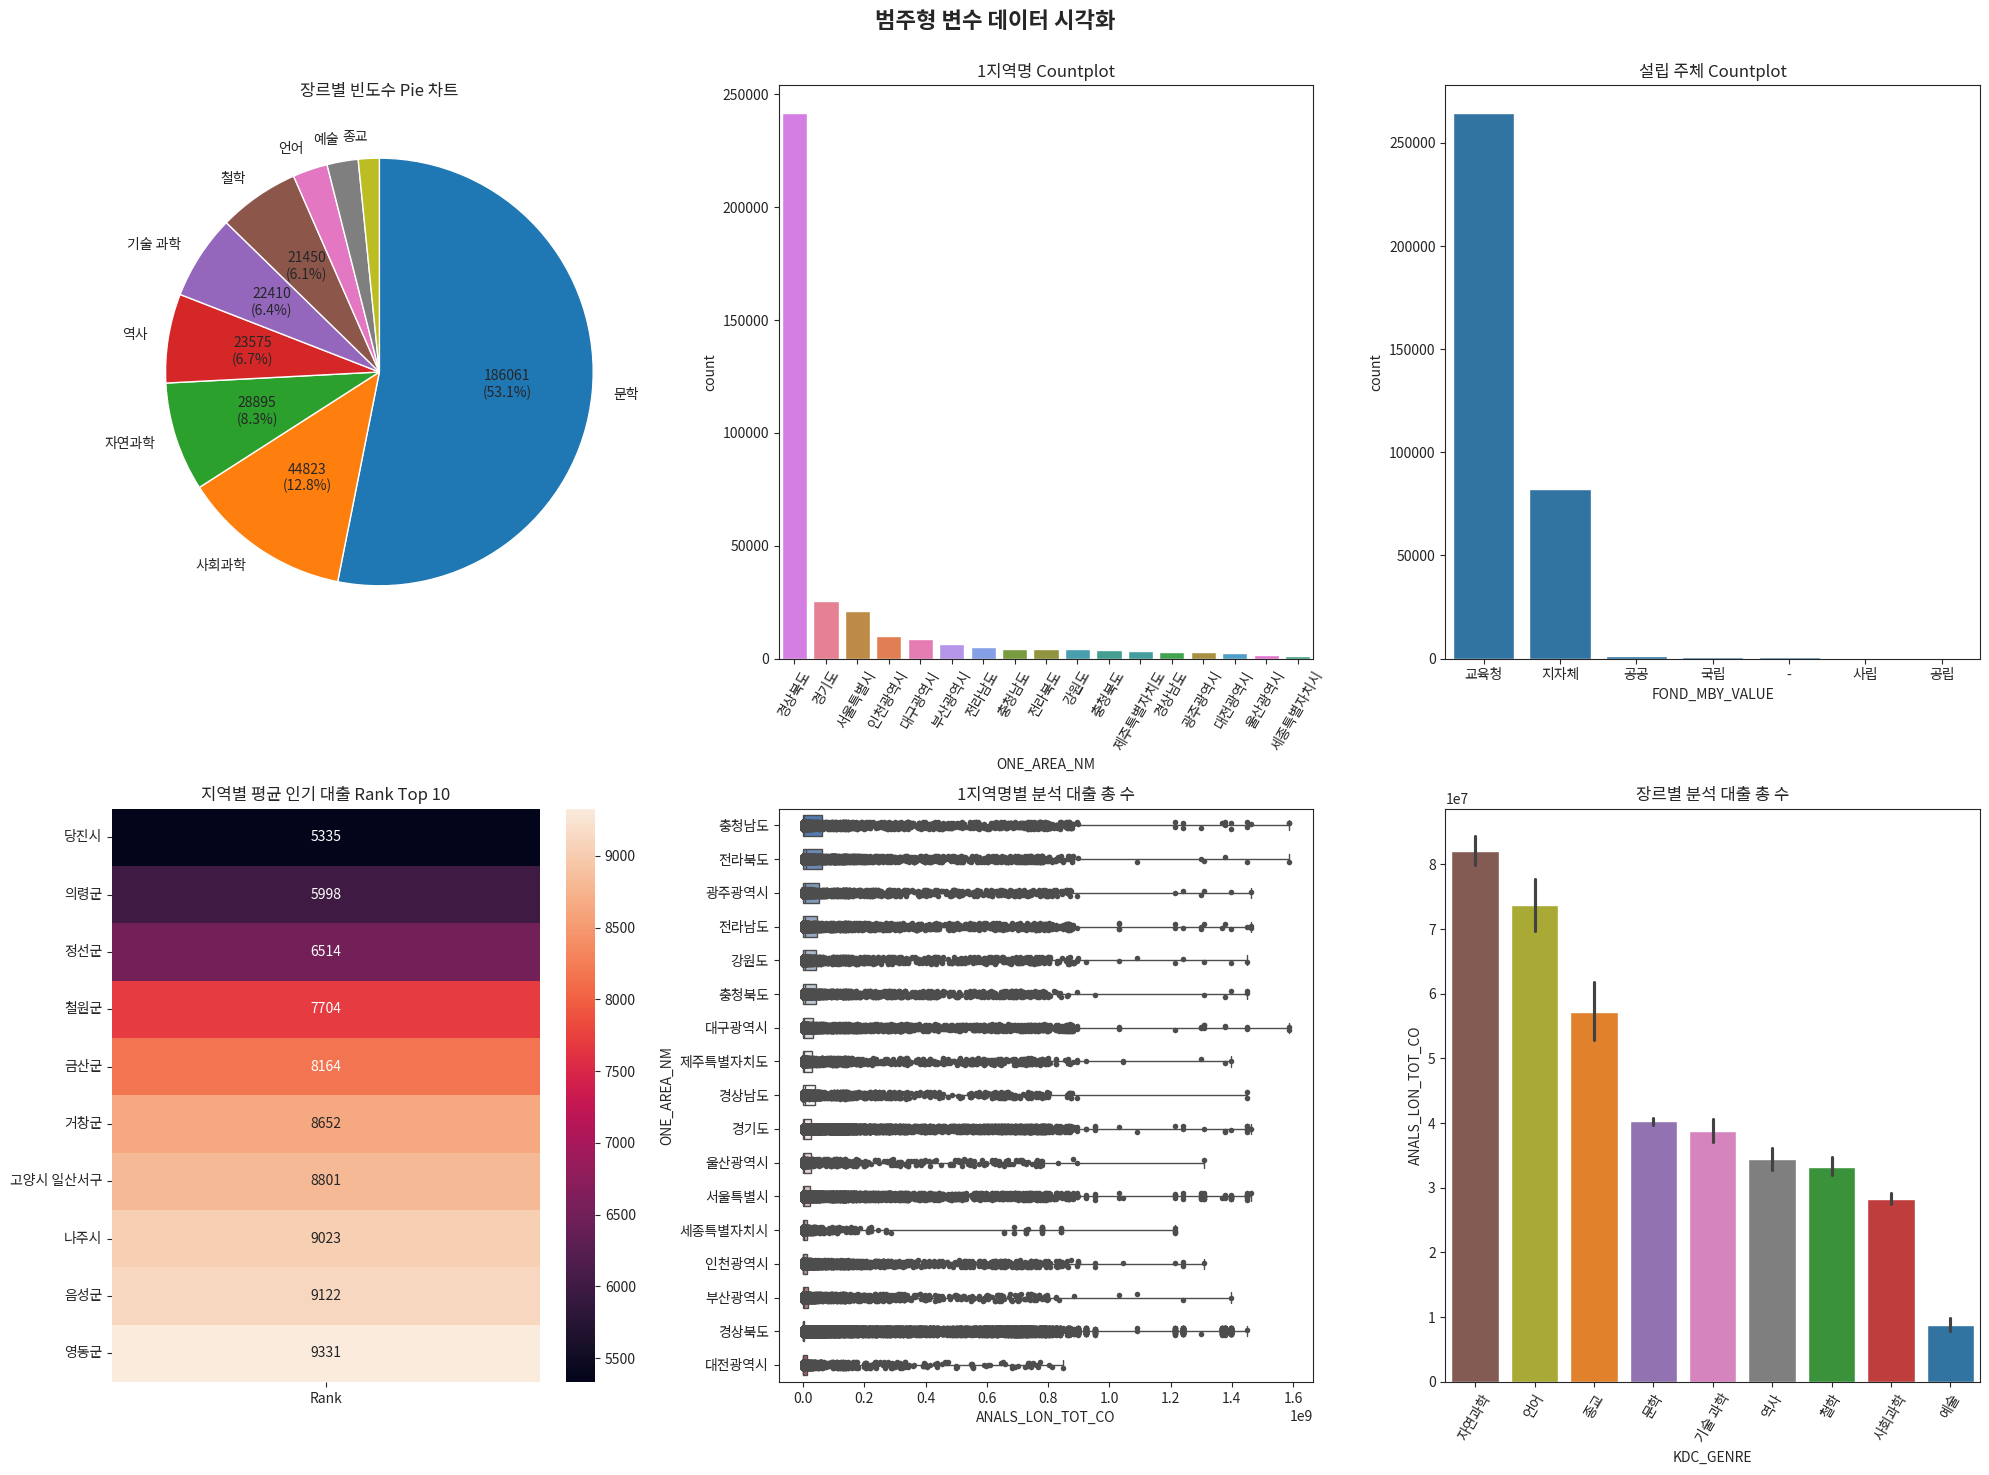

In [36]:
# 전체 subplot 생성 (3행 2열, 총 6개의 plot)
fig, axs = plt.subplots(2, 3, figsize=(20, 15))
axs = axs.flatten()  # 1차원 배열로 변환하여 인덱스로 접근

# --------------------------------------------------
# Plot 1: KDC_GENRE 빈도수 파이 차트 (axs[0])
genre_counts = merged_dataset["KDC_GENRE"].value_counts()

def make_autopct(values):
    def my_autopct(pct):
        if pct < 6:  # 6% 미만이면 표시하지 않음
            return ''
        total = np.sum(values)
        val = int(round(pct * total / 100.0))
        return f"{val}\n({pct:.1f}%)"
    return my_autopct

axs[0].pie(genre_counts, 
           labels=genre_counts.index, 
           autopct=make_autopct(genre_counts),
           startangle=90,       # 시작 각도 90도
           counterclock=False)   # 시계방향 정렬
axs[0].set_title("장르별 빈도수 Pie 차트")

# --------------------------------------------------
# Plot 2: ONE_AREA_NM의 countplot (axs[1])
one_area_order = merged_dataset["ONE_AREA_NM"].value_counts().index
sns.countplot(data=merged_dataset, x="ONE_AREA_NM", order=one_area_order, ax=axs[1], hue="ONE_AREA_NM")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=60)  # x축 라벨 60도 회전
axs[1].set_title("1지역명 Countplot")

# --------------------------------------------------
# Plot 3: FOND_MBY_VALUE의 countplot (axs[2])
fond_order = merged_dataset["FOND_MBY_VALUE"].value_counts().index
sns.countplot(data=merged_dataset, x="FOND_MBY_VALUE", order=fond_order, ax=axs[2])
axs[2].set_title("설립 주체 Countplot")

# --------------------------------------------------
# Plot 4: TWO_AREA_NM별 평균 Rank의 top10 바 차트 (axs[3])
# 평균 Rank 계산 및 top 10 추출
avg_rank = merged_dataset.groupby('TWO_AREA_NM')['Rank'].mean().reset_index()
top10 = avg_rank.sort_values(by='Rank').head(10)
# TWO_AREA_NM과 ONE_AREA_NM 매핑 테이블 생성 후 merge
mapping = merged_dataset[['TWO_AREA_NM', 'ONE_AREA_NM']].drop_duplicates()
top10 = top10.merge(mapping, on='TWO_AREA_NM', how='left')
# sns.barplot(data=top10, y="TWO_AREA_NM", x="Rank", hue="ONE_AREA_NM", ax=axs[3])
# axs[3].set_title("지역별 평균 인기 대출 Rank Top 10")
sns.heatmap(
    top10[["Rank"]],
    annot=True,
    fmt=".0f",  # 소수점 없이 정수 형식으로 표시 (필요시 ".2f" 등으로 조정 가능)
    yticklabels=top10['TWO_AREA_NM'],
    ax=axs[3]
)
axs[3].set_title("지역별 평균 인기 대출 Rank Top 10")

# # --------------------------------------------------
# # Plot 5: ONE_AREA_NM vs ANALS_LON_TOT_CO 바 차트 (axs[4])
# # ONE_AREA_NM별 ANALS_LON_TOT_CO 평균값을 계산하여 내림차순으로 정렬한 order 생성
# order_one_area = merged_dataset.groupby('ONE_AREA_NM')['ANALS_LON_TOT_CO'].mean().sort_values(ascending=False).index
# # sns.barplot(data=merged_dataset, x="ONE_AREA_NM", y="ANALS_LON_TOT_CO", order=order_one_area, ax=axs[4])
# sns.barplot(data=merged_dataset, x="ONE_AREA_NM", y="ANALS_LON_TOT_CO", order=order_one_area, ax=axs[4])
# axs[4].set_xticklabels(axs[4].get_xticklabels(), rotation=60)
# axs[4].set_title("ONE_AREA_NM vs ANALS_LON_TOT_CO (Sorted Descending)")
# ONE_AREA_NM별 ANALS_LON_TOT_CO 평균값을 계산하여 내림차순 정렬한 order 생성
order_one_area = merged_dataset.groupby('ONE_AREA_NM')['ANALS_LON_TOT_CO'].mean().sort_values(ascending=False).index

# Plot 5: Boxplot과 Stripplot을 이용한 ONE_AREA_NM vs ANALS_LON_TOT_CO 시각화 (axs[4])
sns.boxplot(
    data=merged_dataset, 
    x="ANALS_LON_TOT_CO", 
    y="ONE_AREA_NM",
    order=order_one_area,
    whis=[0, 100], 
    width=0.6, 
    palette="vlag",
    ax=axs[4]
)

# 각 관측치를 표시하는 Stripplot 추가
sns.stripplot(
    data=merged_dataset, 
    x="ANALS_LON_TOT_CO", 
    y="ONE_AREA_NM",
    order=order_one_area,
    size=4, 
    color=".3",
    ax=axs[4]
)

axs[4].set_title("1지역명별 분석 대출 총 수")

# --------------------------------------------------
# Plot 6: KDC_GENRE vs ANALS_LON_TOT_CO 바 차트 (axs[5])
# KDC_GENRE별 ANALS_LON_TOT_CO 평균값을 계산하여 내림차순으로 정렬한 order 생성
order_genre = merged_dataset.groupby('KDC_GENRE')['ANALS_LON_TOT_CO'].mean().sort_values(ascending=False).index
sns.barplot(data=merged_dataset, x="KDC_GENRE", y="ANALS_LON_TOT_CO", order=order_genre, ax=axs[5], hue="KDC_GENRE")
axs[5].set_xticklabels(axs[5].get_xticklabels(), rotation=60)
axs[5].set_title("장르별 분석 대출 총 수")

# 최종 레이아웃 간격 자동 조정 후 출력
plt.suptitle("범주형 변수 데이터 시각화", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [25]:
# Treemap 생성
fig = px.treemap(
    merged_dataset, 
    path=['ONE_AREA_NM', 'KDC_GENRE'], 
    values='ANALS_LON_TOT_CO',
    color='ANALS_LON_TOT_CO', 
    color_continuous_scale='balance'
)

# Title 추가 (가운데 정렬)
fig.update_layout(
    title={
        'text': "1지역명에 따른 장르별 분석 대출 총 수 Treemap",
        'x': 0.5,  # 제목을 가운데로 배치
        'xanchor': 'center'
    }
)

# Treemap 표시
fig.show()

### 3-2. 상관 관계 확인

In [ ]:
# 상관관계 확인
df_corr = merged_dataset[num_cols].corr()
df_corr.style.background_gradient()

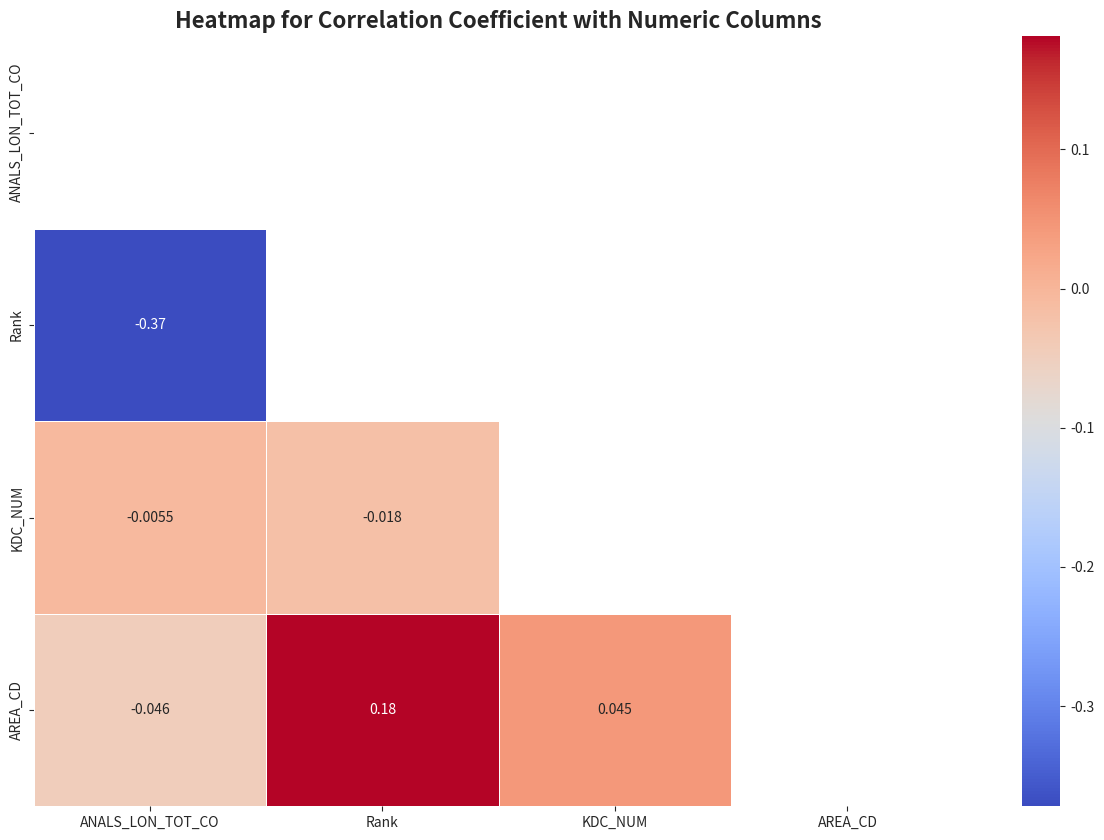

In [133]:
plt.figure(figsize=(15,10))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_corr,
            annot=True,         # 실제 값을 표시한다
            mask=mask,          # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,      # 경계면 실선으로 구분하기
            cmap='coolwarm')

plt.title("Heatmap for Correlation Coefficient with Numeric Columns", fontsize=16, fontweight='bold')
plt.show()